In [1]:
import datetime
import math
import pandas as pd
import numpy as np
import pandas_datareader.data as data
from pandas.plotting import scatter_matrix
from pandas import Series, DataFrame
import copy

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib as mpl

In [2]:
# setting the timeframe for our data
past = datetime.datetime(2015, 1, 1)
present = datetime.datetime(2020, 4, 5)

# Yahoo API google finance data
google = data.DataReader("GOOG", 'yahoo', start=past, end=present)
google.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-03-30,1151.630005,1096.479980,1125.040039,1146.819946,2574100.0,1146.819946
2020-03-31,1175.310059,1138.140015,1147.300049,1162.810059,2486400.0,1162.810059
2020-04-01,1129.689941,1097.449951,1122.000000,1105.619995,2344200.0,1105.619995
2020-04-02,1126.859985,1096.400024,1098.260010,1120.839966,1964900.0,1120.839966
2020-04-03,1123.540039,1079.810059,1119.015015,1097.880005,2312200.0,1097.880005


In [3]:
# moving average mean of closing data for past 6 months
googleClose = google['Adj Close']
avgMean = googleClose.rolling(window=180).mean()

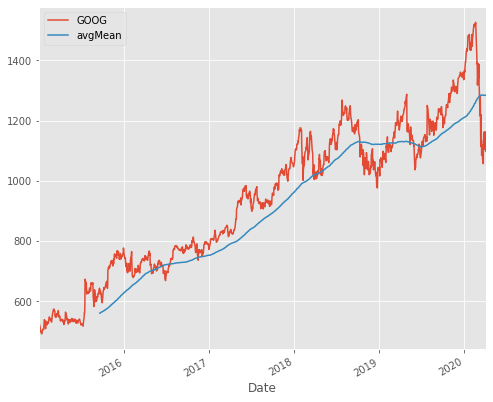

In [4]:
# matplotlib plot of Google data
mpl.rc('figure', figsize=(8, 7))
mpl.__version__


style.use('ggplot')
googleClose.plot(label='GOOG')
avgMean.plot(label='avgMean')
plt.legend()

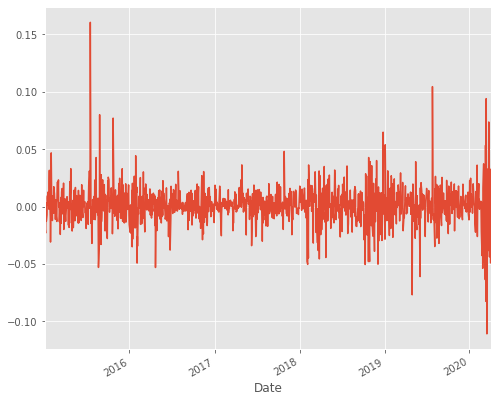

In [5]:
# returns
returns = googleClose / googleClose.shift(1) - 1
returns.plot(label='return')

In [6]:
# Yahoo finance API data 
df = data.DataReader(['AAPL', 'GE', 'GOOG', 'IBM', 'MSFT'],'yahoo',start=past,end=present)
df.tail()

Attributes   Adj Close                                                  Close  \
Symbols           AAPL    GE         GOOG         IBM        MSFT        AAPL   
Date                                                                            
2020-03-30  254.809998  7.89  1146.819946  112.930000  160.229996  254.809998   
2020-03-31  254.289993  7.94  1162.810059  110.930000  157.710007  254.289993   
2020-04-01  240.910004  7.04  1105.619995  105.139999  152.110001  240.910004   
2020-04-02  244.929993  6.90  1120.839966  110.000000  155.259995  244.929993   
2020-04-03  241.410004  6.73  1097.880005  106.339996  153.830002  241.410004   

Attributes                                             ...        Open        \
Symbols       GE         GOOG         IBM        MSFT  ...        AAPL    GE   
Date                                                   ...                     
2020-03-30  7.89  1146.819946  112.930000  160.229996  ...  250.740005  7.54   
2020-03-31  7.94  1162.810059  110.930000  157.710007  ...  255.600006  7.87   
2020-04-01  7.04  1105.619995  105.139999  152.110001  ...  246.500000  7.52   
2020-04-02  6.90  1120.839966  110.000000  155.259995  ...  240.339996  7.02   
2020-04-03  6.73  1097.880005  106.339996  153.830002  ...  242.800003  7.03   

Attributes                                           Volume               \
Symbols            GOOG         IBM        MSFT        AAPL           GE   
Date                                                                       
2020-03-30  1125.040039  108.089996  152.440002  41994100.0   86850200.0   
2020-03-31  1147.300049  112.000000  159.399994  49250500.0  121149900.0   
2020-04-01  1122.000000  106.360001  153.000000  44054600.0   99556900.0   
2020-04-02  1098.260010  105.370003  151.860001  41483500.0   97498400.0   
2020-04-03  1119.015015  108.919998  155.100006  32418200.0   97730200.0   

Attributes                                    
Symbols          GOOG        IBM        MSFT  
Date                                          
2020-03-30  2574100.0  5564500.0  63420300.0  
2020-03-31  2486400.0  6343300.0  77927200.0  
2020-04-01  2344200.0  6112900.0  57969900.0  
2020-04-02  1964900.0  6328700.0  49630700.0  
2020-04-03  2312200.0  4538100.0  41212700.0  

[5 rows x 30 columns]

In [7]:
df = data.DataReader(['AAPL', 'GE', 'GOOG', 'IBM', 'MSFT'],'yahoo',start=past,end=present)['Adj Close']
df.tail()

Symbols,AAPL,GE,GOOG,IBM,MSFT
Date,,,,,
2020-03-30,254.809998,7.89,1146.819946,112.930000,160.229996
2020-03-31,254.289993,7.94,1162.810059,110.930000,157.710007
2020-04-01,240.910004,7.04,1105.619995,105.139999,152.110001
2020-04-02,244.929993,6.90,1120.839966,110.000000,155.259995
2020-04-03,241.410004,6.73,1097.880005,106.339996,153.830002


In [8]:
# correlation plot
correlation = df.pct_change()
corr = correlation.corr()
corr

Symbols,AAPL,GE,GOOG,IBM,MSFT
Symbols,,,,,
AAPL,1.000000,0.425572,0.612770,0.520700,0.675469
GE,0.425572,1.000000,0.387741,0.483192,0.428808
GOOG,0.612770,0.387741,1.000000,0.512644,0.721621
IBM,0.520700,0.483192,0.512644,1.000000,0.588624
MSFT,0.675469,0.428808,0.721621,0.588624,1.000000


Text(0, 0.5, 'Microsoft Returns')

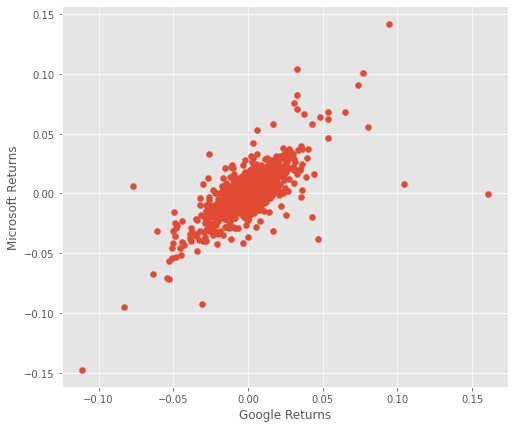

In [9]:
plt.scatter(correlation.GOOG, correlation.MSFT)
plt.xlabel('Google Returns')
plt.ylabel('Microsoft Returns')

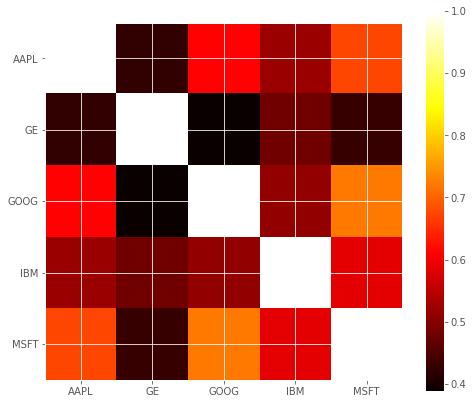

In [10]:
plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns);

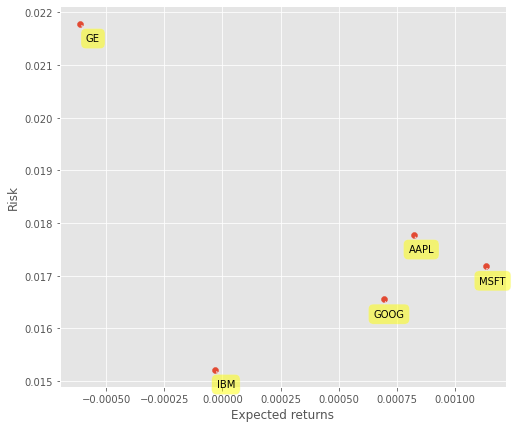

In [11]:
plt.scatter(correlation.mean(), correlation.std())
plt.xlabel('Expected returns')
plt.ylabel('Risk')
for label, x, y in zip(correlation.columns, correlation.mean(), correlation.std()):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (20, -20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

In [12]:
google.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-03-30,1151.630005,1096.479980,1125.040039,1146.819946,2574100.0,1146.819946
2020-03-31,1175.310059,1138.140015,1147.300049,1162.810059,2486400.0,1162.810059
2020-04-01,1129.689941,1097.449951,1122.000000,1105.619995,2344200.0,1105.619995
2020-04-02,1126.859985,1096.400024,1098.260010,1120.839966,1964900.0,1120.839966
2020-04-03,1123.540039,1079.810059,1119.015015,1097.880005,2312200.0,1097.880005


In [13]:
dfFeat = google.loc[:,['Adj Close','Volume']]
dfFeat['HL_PCT'] = (google['High'] - google['Low']) / google['Close'] * 100.0
dfFeat['PCT_change'] = (google['Close'] - google['Open']) / google['Open'] * 100.0

In [14]:
dfFeat.fillna(value=-99999, inplace=True)
# forecasting 5% of data and predicting the AdjCllose
forecast_col = 'Adj Close'
forecast_out = int(math.ceil(0.05 * len(dfFeat)))
dfFeat['label'] = dfFeat[forecast_col].shift(-forecast_out)
dfFeat.dropna(inplace=True)
dfFeat.head()

,Adj Close,Volume,HL_PCT,PCT_change,label
Date,,,,,
2015-01-02,523.373108,1447500.0,1.366201,-0.793931,538.531433
2015-01-05,512.463013,2059800.0,2.193166,-1.794524,537.693787
2015-01-06,500.585632,2899900.0,3.013188,-2.532046,528.937805
2015-01-07,499.727997,2065000.0,1.515467,-1.163709,531.071960
2015-01-08,501.303680,3353500.0,2.482693,0.941785,532.338440


In [15]:
X = np.array(dfFeat.drop(['label'],1))
y = np.array(dfFeat['label'])
X = preprocessing.scale(X)
X_late = X[-forecast_out:]
y = np.array(dfFeat['label'])

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state=2)

In [17]:
# Linear regression
linearReg = LinearRegression()
linearReg.fit(X_train, y_train)

y_predict = linearReg.predict(X_test)
accuracy = linearReg.score(X_test, y_test)

print("Prediction Accuracy: %.1f%%" % (accuracy * 100.0))

Prediction Accuracy: 85.0%


In [18]:
# KNN Regression
knnReg = KNeighborsRegressor(n_neighbors=3)
knnReg.fit(X_train, y_train)

y_predict = knnReg.predict(X_test)
accuracy = knnReg.score(X_test, y_test)

print("Prediction Accuracy: %.1f%%" % (accuracy * 100.0))

Prediction Accuracy: 83.8%


In [19]:
forecastStock = linearReg.predict(X_late)
dfFeat['Forecast'] = np.nan

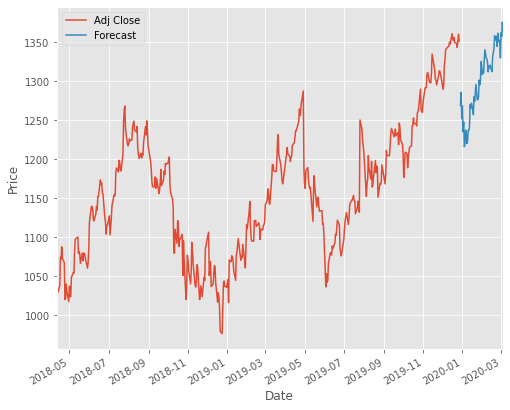

In [20]:
dateRecent = dfFeat.iloc[-1].name
nextCalc = dateRecent + datetime.timedelta(days=1)

for i in forecastStock:
    datePred = nextCalc
    nextCalc += datetime.timedelta(days=1)
    dfFeat.loc[nextCalc] = [np.nan for _ in range(len(dfFeat.columns)-1)]+[i]
dfFeat['Adj Close'].tail(500).plot()
dfFeat['Forecast'].tail(500).plot()
plt.legend(loc=2)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [21]:
# setting the timeframe for our data gathering
past = datetime.datetime(2020, 1, 1)
present = datetime.datetime(2020, 4, 5)

# Yahoo API google finance data
google = data.DataReader("GOOG", 'yahoo', start=past, end=present)
google.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-03-30,1151.630005,1096.479980,1125.040039,1146.819946,2574100,1146.819946
2020-03-31,1175.310059,1138.140015,1147.300049,1162.810059,2486400,1162.810059
2020-04-01,1129.689941,1097.449951,1122.000000,1105.619995,2344200,1105.619995
2020-04-02,1126.859985,1096.400024,1098.260010,1120.839966,1964900,1120.839966
2020-04-03,1123.540039,1079.810059,1119.015015,1097.880005,2312200,1097.880005


In [22]:
# moving average mean of closing data for past 6 months
googleClose = google['Adj Close']
avgMean = googleClose.rolling(window=180).mean()

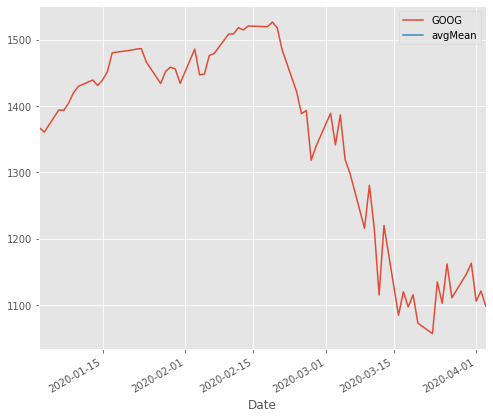

In [23]:
# matplotlib plot of Google data
mpl.rc('figure', figsize=(8, 7))
mpl.__version__


style.use('ggplot')
googleClose.plot(label='GOOG')
avgMean.plot(label='avgMean')
plt.legend()

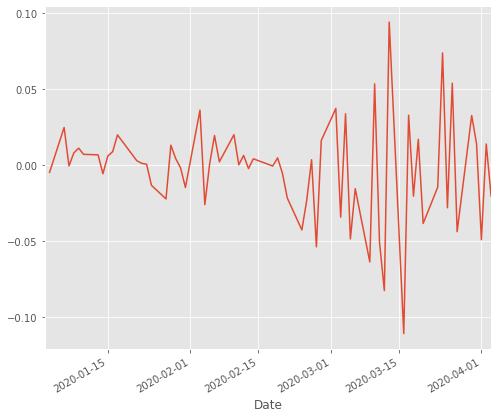

In [24]:
# returns
returns = googleClose / googleClose.shift(1) - 1
returns.plot(label='return')

In [25]:
df = data.DataReader(['AAPL', 'GE', 'GOOG', 'IBM', 'MSFT'],'yahoo',start=past,end=present)
df.tail()

Attributes   Adj Close                                                  Close  \
Symbols           AAPL    GE         GOOG         IBM        MSFT        AAPL   
Date                                                                            
2020-03-30  254.809998  7.89  1146.819946  112.930000  160.229996  254.809998   
2020-03-31  254.289993  7.94  1162.810059  110.930000  157.710007  254.289993   
2020-04-01  240.910004  7.04  1105.619995  105.139999  152.110001  240.910004   
2020-04-02  244.929993  6.90  1120.839966  110.000000  155.259995  244.929993   
2020-04-03  241.410004  6.73  1097.880005  106.339996  153.830002  241.410004   

Attributes                                             ...        Open        \
Symbols       GE         GOOG         IBM        MSFT  ...        AAPL    GE   
Date                                                   ...                     
2020-03-30  7.89  1146.819946  112.930000  160.229996  ...  250.740005  7.54   
2020-03-31  7.94  1162.810059  110.930000  157.710007  ...  255.600006  7.87   
2020-04-01  7.04  1105.619995  105.139999  152.110001  ...  246.500000  7.52   
2020-04-02  6.90  1120.839966  110.000000  155.259995  ...  240.339996  7.02   
2020-04-03  6.73  1097.880005  106.339996  153.830002  ...  242.800003  7.03   

Attributes                                           Volume               \
Symbols            GOOG         IBM        MSFT        AAPL           GE   
Date                                                                       
2020-03-30  1125.040039  108.089996  152.440002  41994100.0   86850200.0   
2020-03-31  1147.300049  112.000000  159.399994  49250500.0  121149900.0   
2020-04-01  1122.000000  106.360001  153.000000  44054600.0   99556900.0   
2020-04-02  1098.260010  105.370003  151.860001  41483500.0   97498400.0   
2020-04-03  1119.015015  108.919998  155.100006  32418200.0   97730200.0   

Attributes                                    
Symbols          GOOG        IBM        MSFT  
Date                                          
2020-03-30  2574100.0  5564500.0  63420300.0  
2020-03-31  2486400.0  6343300.0  77927200.0  
2020-04-01  2344200.0  6112900.0  57969900.0  
2020-04-02  1964900.0  6328700.0  49630700.0  
2020-04-03  2312200.0  4538100.0  41212700.0  

[5 rows x 30 columns]

In [26]:
df = data.DataReader(['AAPL', 'GE', 'GOOG', 'IBM', 'MSFT'],'yahoo',start=past,end=present)['Adj Close']
df.tail()

Symbols,AAPL,GE,GOOG,IBM,MSFT
Date,,,,,
2020-03-30,254.809998,7.89,1146.819946,112.930000,160.229996
2020-03-31,254.289993,7.94,1162.810059,110.930000,157.710007
2020-04-01,240.910004,7.04,1105.619995,105.139999,152.110001
2020-04-02,244.929993,6.90,1120.839966,110.000000,155.259995
2020-04-03,241.410004,6.73,1097.880005,106.339996,153.830002


In [27]:
# correlation plot
correlation = df.pct_change()
corr = correlation.corr()
corr

Symbols,AAPL,GE,GOOG,IBM,MSFT
Symbols,,,,,
AAPL,1.000000,0.819356,0.916874,0.823572,0.936465
GE,0.819356,1.000000,0.794026,0.757581,0.803840
GOOG,0.916874,0.794026,1.000000,0.823578,0.927818
IBM,0.823572,0.757581,0.823578,1.000000,0.821675
MSFT,0.936465,0.803840,0.927818,0.821675,1.000000


Text(0, 0.5, 'Microsoft Returns')

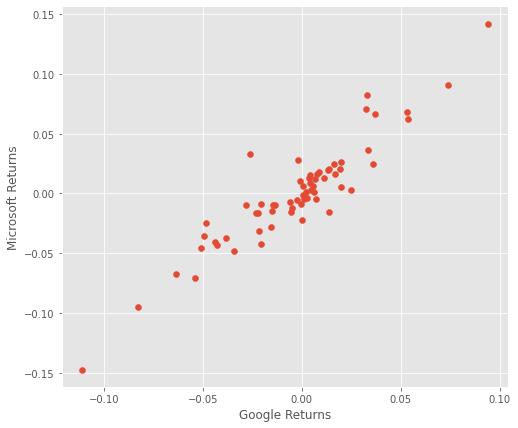

In [28]:
plt.scatter(correlation.GOOG, correlation.MSFT)
plt.xlabel('Google Returns')
plt.ylabel('Microsoft Returns')

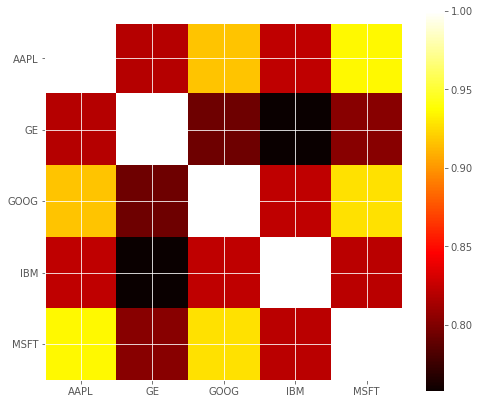

In [29]:
plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns);

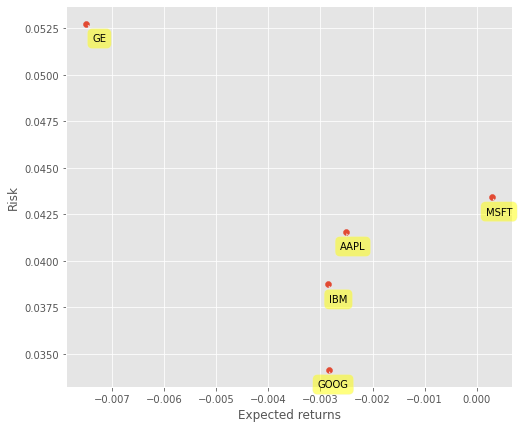

In [30]:
plt.scatter(correlation.mean(), correlation.std())
plt.xlabel('Expected returns')
plt.ylabel('Risk')
for label, x, y in zip(correlation.columns, correlation.mean(), correlation.std()):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (20, -20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))